In [1]:
import os
import requests
import pandas as pd
import io
import urllib.request
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
import pylab as pp
# Technical Analysis library
import ta

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

pp.style.use("bmh")

In [2]:
os.chdir('D:/Stocks/')
file = 'stock names.csv'
codes = pd.read_csv(file)

In [3]:
# code = str(codes.Codes[5])

stock_name = 'ولساپا'
code_number = codes.Name.tolist().index(stock_name)
code = str(codes.Code[code_number])

# code = '65883838195688438'

url = "http://www.tsetmc.com/tsev2/data/Export-txt.aspx?t=i&a=1&b=0&i=" + code
r = requests.get(url, allow_redirects=True).content

# open('7769065543658313.csv', 'wb').write(r.content);

In [4]:
df = pd.read_csv(io.StringIO(r.decode('utf-8')))
print(df['<TICKER>'][0])

S*Rayan.Saipa


In [5]:
## Datetime conversion
df['<DTYYYYMMDD>'] = pd.to_datetime(df['<DTYYYYMMDD>'], format='%Y%m%d')
df.rename(columns={"<DTYYYYMMDD>": "Date"}, inplace=True)
df['Date'] =pd.to_datetime(df.Date)
df = df.sort_values(by=['Date'])

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

In [6]:
## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="<OPEN>", high="<HIGH>", low="<LOW>", close="<CLOSE>", volume="<VOL>", fillna=True)

c:\users\light\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\light\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [7]:
# Dropping everything else besides 'Close' and the Indicators
df.drop(['<TICKER>', '<FIRST>', '<HIGH>', '<LOW>', '<VALUE>', '<VOL>', '<OPENINT>', '<PER>', '<OPEN>', '<LAST>'], axis=1, inplace=True)

df.rename(columns={"<CLOSE>": "Close", "<DTYYYYMMDD>": "Date"}, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = df.tail(1500)

In [8]:
## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [9]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    pp.figure(figsize=(16,5))
    pp.plot(history['val_loss'])
    pp.plot(history['loss'])
    pp.legend(['val_loss', 'loss'])
    pp.title('Loss')
    pp.xlabel('Epochs')
    pp.ylabel('Loss')
    pp.show()
    
    pp.figure(figsize=(16,5))
    pp.plot(history['val_accuracy'])
    pp.plot(history['accuracy'])
    pp.legend(['val_accuracy', 'accuracy'])
    pp.title('Accuracy')
    pp.xlabel('Epochs')
    pp.ylabel('Accuracy')
    pp.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          

def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [10]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [11]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "relu"

# Input layer
model.add(LSTM(50, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=50, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=3, batch_size=128, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            24800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                26640     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
Total params: 73,470
Trainable params: 73,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
10/10 [==============================] - 3s 312ms/step - loss: 4.1758 - accuracy: 0.0209 - val_loss: 20.4713 - val_accuracy: 0.0360
Epoch 2/3
10/10 [==============================] - 2s 247ms/step - loss: 0.2727 - accuracy: 0.0274 - val_los

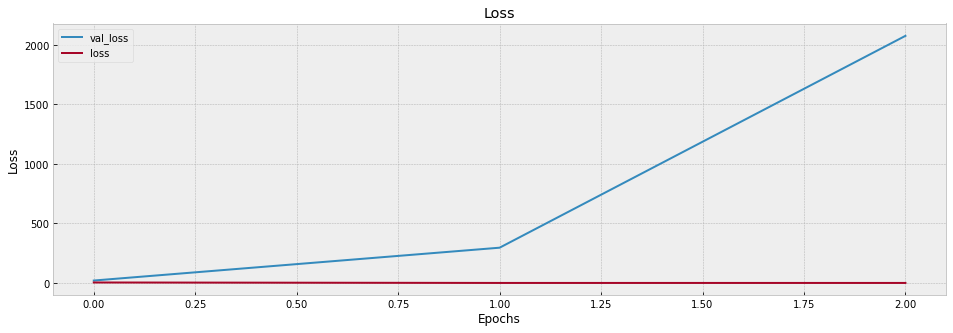

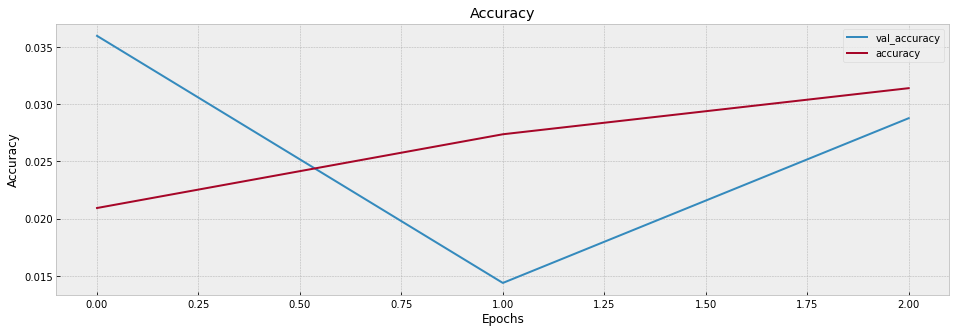

In [12]:
visualize_training_results(res)

RMSE: 875.1804065049356


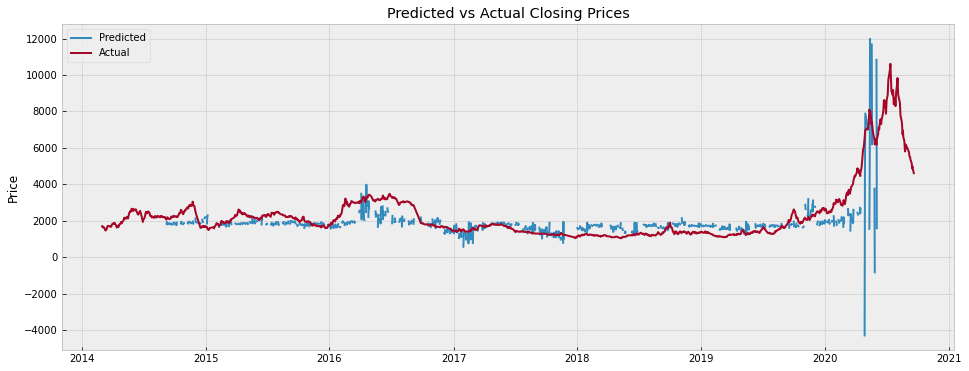

In [13]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
pp.figure(figsize=(16,6))

# Plotting those predictions
pp.plot(predictions, label='Predicted')

# Plotting the actual values
pp.plot(actual, label='Actual')

pp.title(f"Predicted vs Actual Closing Prices")
pp.ylabel("Price")
pp . legend ()
# pp . xlim ( '2015-05-01' , '2020-05-01' )
pp.show()

                   Close
2020-09-21 -3.149727e+07
2020-09-22  4.077662e+07
2020-09-23 -1.837362e+07
2020-09-24  9.325133e+05
2020-09-25 -1.604271e+07
2020-09-28 -1.427050e+07
2020-09-29 -2.284653e+07
2020-09-30  4.233834e+07
2020-10-01 -2.741318e+07
2020-10-02  3.450680e+07
2020-10-05  2.460983e+07
2020-10-06  1.690636e+07
2020-10-07 -2.482189e+06
2020-10-08  1.080833e+07
2020-10-09 -2.053389e+06
2020-10-12  6.391286e+06
2020-10-13  1.927332e+07
2020-10-14  3.489185e+06
2020-10-15  1.159714e+07
2020-10-16 -3.467201e+07
2020-10-19  7.363190e+06
2020-10-20  6.520292e+06
2020-10-21  1.422206e+07
2020-10-22 -3.744893e+07
2020-10-23  1.990533e+07
2020-10-26  1.608128e+07
2020-10-27  3.860258e+06
2020-10-28  4.147424e+06
2020-10-29 -7.798714e+05
2020-10-30 -3.249933e+07


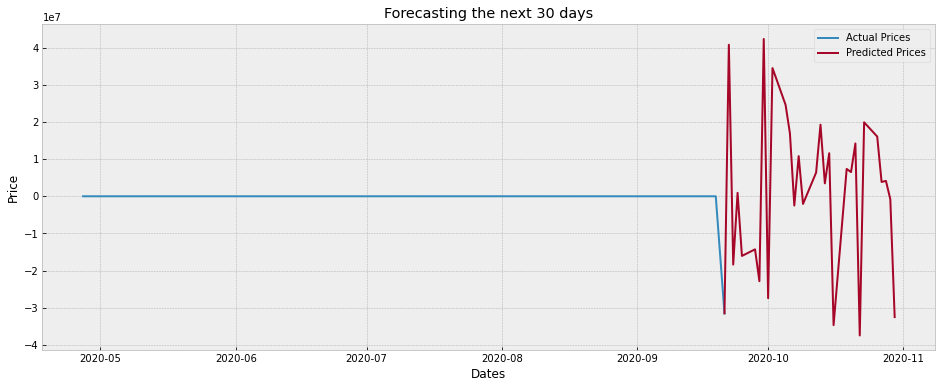

In [14]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
pp.figure(figsize=(16,6))
pp.plot(actual, label="Actual Prices")
pp.plot(preds, label="Predicted Prices")
pp.ylabel("Price")
pp.xlabel("Dates")
pp.title(f"Forecasting the next {len(yhat)} days")
pp . legend ()
pp.show()